# Unit Introduction

## Learning objectives for this practical session

* Learn to do the following via SKLearn and ultimately develop your own versions
  * Data preprocessing
  * Exploratory data analysis
  * KNN for Classification
  * Pipelines: Machine learning workflows
  * KNN for Regression
* Start Homework assignment 1 
  * Develop KNN from scratch  
  * apply KNN to an image classification task
  * Benchmark your approach against logistic regression
  * Do a Kaggle submission (this is optional)

## Tasks
1. Predict the wine quality score using KNN Classification using an optimal value of K (using CV)
* Discover Pipelines in scikit-learn and how you can automate common machine learning workflows (e.g., determine optimal value of K). 
  * Use Pipeline, and crossfoldvalidation to determine the optimal value of K for KNN model Pima Indian Diabetes Classification task 
* Predict the life satisfaction for Cyprus based on GDP using KNN with K=1, K=5 (versus a linear regression model)

## Some background

Data preprocessing is an umbrella term that covers an array of operations data scientists will use to get their data into a form more appropriate for what they want to do with it. For example, before performing sentiment analysis of twitter data, you may want to strip out any html tags, white spaces, expand abbreviations and split the tweets into lists of the words they contain. When analyzing spatial data you may scale it so that it is unit-independent, that is, so that your algorithm doesn't care whether the original measurements were in miles or centimeters. However, preprocessing data does not occur in a vacuum. This is just to say that preprocessing is a means to an end and there are no hard and fast rules: there are standard practices, as we shall see, and you can develop an intuition for what will work but, in the end, preprocessing is generally part of a results-oriented pipeline and its performance needs to be judged in context.

In this article, I'll use the example of scaling numerical data (numerical data: data consisting of numbers, as opposed to categories/strings; scaling: using basic arithmetic to change the range of the data; more details to follow) to demonstrate the importance of considering preprocessing as part of a greater structure, the machine learning (ML) pipeline. To this end, we'll see a real-world example in which scaling can improve model performance.

I'll first introduce classification problems in ML and k-Nearest Neighbors, one of the simplest algorithms used in such settings. To appreciate the importance of scaling numerical data in such a setting, I'll need to introduce measures of model performance and the concepts of training and test sets. You'll see all these concepts and practices at play with a dataset in which I attempt to classify the quality of red wine. I'll also make sure that I put preprocessing in its most useful place, near the beginning of an iterative data science pipeline. All examples herein will be in Python. If you're not familiar with Python, you can check out our DataCamp courses <a href = 'https://www.datacamp.com/'>here</a>. I will make use of the libraries <a href = 'http://pandas.pydata.org/'>pandas</a> for our dataframe needs and <a href = 'http://scikit-learn.org/stable/'>scikit-learn</a> for our machine learning needs.

# A brief introduction to classification problems in machine learning

Classifying and labelling things in the phenomenal world is an ancient art. In the 4th century BC, Aristotle constructed a classification system of living things that was used for 2,000 years. In the modern world, classification is commonly framed as a machine learning task, in particular, a supervised learning task. The basic principle of supervised learning is straightforward: we have a bunch of data consisting of *predictor variables* and a *target variable*. The aim of **supervised learning** is to build a model that is 'good at' predicting the target variable, given the predictor variables. If the target variable consists of categories (e.g. 'click' or 'not', 'malignant' or 'benign' tumor), we call the learning task **classification**. Alternatively, if the target is a continuously varying variable (e.g. price of a house), it is a **regression** task. 

An illustrative example will go a long way here: consider the <a href='http://archive.ics.uci.edu/ml/datasets/Heart+Disease'>heart disease dataset</a>, in which there are 75 predictor variables, such as 'age', 'sex' and 'smoker or not' and the target variable refers to the presence of heart disease and ranges from 0 (no heart disease) to 4. Much work on this dataset has concentrated on attempts to distinguish the presence of heart disease from its absence. This is a classification task. If you were to attempt to predict the actual value (0 to 4) of the target variable, this would be a regression problem (because the target variable is ordered). I'll discuss regression in the next post. Here I'll look at one of the simplest algorithms for classification tasks, the **k-Nearest Neighbors algorithm**.

# k-Nearest Neighbors for classification in machine learning

Let's say that we have some labeled data, for example, data that consists of characteristics of red wine (e.g. alcohol content, density, amount of citric acid, pH, etc...; these are the predictor variables) with target variable 'Quality' and labels 'good' & 'bad'. Then, given the characteristics of a new, unlabeled wine, the classification task is to predict its 'Quality'. When all the predictor variables are numerical (there are also ways to deal with the categorical case), we can consider each row/wine as a point in n-dimensional space and, in this case, k-Nearest Neighbors (k-NN) is a conceptually & computationally simple classification method: for each new, unlabeled wine, we calculate, for some integer k, its k nearest neighbors in the n-dimensional predictor variable space. Then we look at the labels of these k neighbors (i.e. 'good' or 'bad') & assign the label with the most hits to the new wine (e.g. if k = 5, 3 neighbors vote 'good' and 2 vote 'bad', then our model labels the new wine 'good'). Note that, here, training the model consists entirely in storing the data points: there are no parameters to fit!

#### A visual description of k-Nearest Neighbors

In the image below, there's an example of k-NN in 2D: how do you classsify the data point in the middle? Well, if k=3, you would clasify it as red and, if k=5, as green. 

In [1]:
from IPython.display import Image
Image(url= 'http://36.media.tumblr.com/d100eff8983aae7c5654adec4e4bb452/tumblr_inline_nlhyibOF971rnd3q0_500.png')

#### EDA: Wine Quality Dataset

Let's now see an example of k-NN at work. To do so, we'll check out the <a href='http://archive.ics.uci.edu/ml/datasets/Wine+Quality'>wine quality dataset</a>: we'll import it into a pandas dataframe and then plot histograms of the predictor variables to get a feel for the data.

Attribute Information:

For more information, read [Cortez et al., 2009]. 
Input variables (based on physicochemical tests): 
1. - fixed acidity 
2. - volatile acidity 
3. - citric acid 
4. - residual sugar 
5. - chlorides 
6. - free sulfur dioxide 
7. - total sulfur dioxide 
8. - density 
9. - pH 
10. - sulphates 
11. - alcohol 
Output variable (based on sensory data): 
12 - quality (score between 0 and 10)



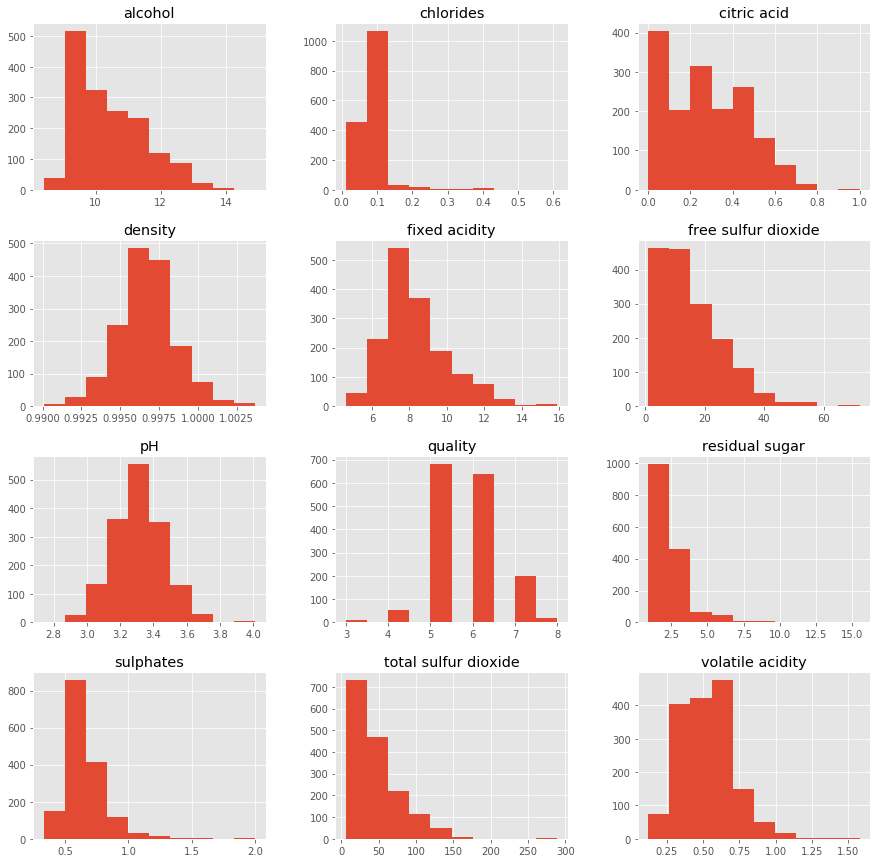

In [15]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv ' , sep = ';')
X = df.drop('quality' , 1).values # drop target variable
y1 = df['quality'].values
pd.DataFrame.hist(df, figsize = [15,15]);

First notice the range of the predictor variables: 'free sulfur dioxide' ranges from 0 to ~70 and 'volatile acidity' from ~0 to ~1.2. More specifically, the former has a range 2 orders of magnitude larger than that of the latter. Any algorithm, such as k-NN, which cares about the distance between data points, may thus focus squarely and unfairly on variables with a larger range, such as 'free sulfur dioxide', a variable that may contain only noise, for all we know. This motivates scaling our data, which we'll get to soon enough.

Now the target variable is a 'Quality' rating of wine and ranges from 3 to 8. For the purpose of expositional ease, let's turn it into a two-category variable consisting of 'good' (rating > 5) & 'bad' (rating <= 5). We'll also plot histograms of both formulations of the target variable to get a sense of what's going on.

#### Convert target variable `Quality` rating to a categorical variable

In [19]:
y= (y1 <= 5) # is the rating <= 5?
y=y.astype(np.float32)
y 

array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)

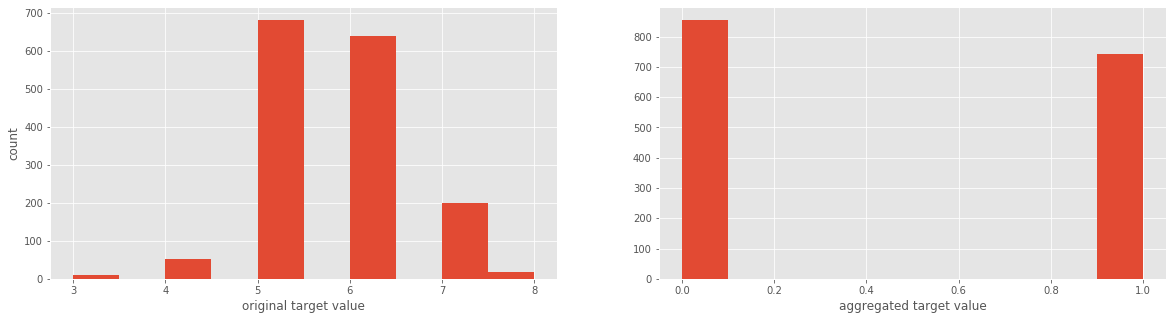

In [21]:
# plot histograms of original target variable
# and aggregated target variable
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.hist(y1);
plt.xlabel('original target value')
plt.ylabel('count')
plt.subplot(1, 2, 2);
plt.hist(y)
plt.xlabel('aggregated target value')
plt.show()

Now we're nearly ready to perform k-Nearest Neighbors. First off, though, if we're going to compare how our model performs with and without preprocessing, we'll need to figure out how to measure the 'goodness' of a model:

#### kNN: Metrics

There are a number of performance measures for classification challenges. It is of the utmost importance to realise that the choice of performance measure is deeply domain & question specific. In the case of a dataset with balanced classes (where all target values are ~ equally represented), data scientists commonly look at *accuracy* as a performance measure. In fact, as we'll see, accuracy is the default scoring method for both k-Nearest Neighbors and logistic regression in scikit-learn. So what is accuracy? It is merely the number of correct predictions divided by the total number of predictions:


$$\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}.$$

*Note: **accuracy** can also be defined in terms of a confusion matrix and is commonly defined for binary classification problems in terms of true positives & false negatives; other common measures of model performance derivable from the confusion matrix are **precision**, the number of true positives divided by the number of true & false positives, and **recall**, the number of true positives divided by the number of true positives plus the number of false negatives; yet another measure, the **F1-score** is the harmonic mean of the precision and the recall. See <a href='http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/'>machine learning mastery</a> for a nice exposition of these measures; also check out the Wikipedia entries on the <a href='https://en.wikipedia.org/wiki/Confusion_matrix'>confusion matrix</a> and the <a href='https://en.wikipedia.org/wiki/F1_score'>F1 score</a>.*

#### kNN: performance in practice and the train test split

It is all well and good to have a measure of performance such as accuracy, but if we fit the model on all of the data we have, what dataset are we going we going to report the accuracy from? Remember that we want a model that generalizes well to new data. Thus, if we train our model on a dataset *D*, reporting the accuracy of the model on the same data *D* may make it look as though it performs better than it actually does. This is known as **overfitting**. To combat this issue, data scientists will commonly train their model on a subset of the data, called the **training set** and evaluate its performance on the rest of the data, the **test set**. This is precisely what we're going to do here! A general rule of thumb is to use approximately 80% of the data for training & 20% for test. Let's now split our red wine quality data:

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We now build the k-NN model, make predictions on the test set and compare these predictions to the ground truth in order to get a measure of model performance:

In [24]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_model_1 = knn.fit(X_train, y_train)
print('k-NN accuracy for test set: %f' % knn_model_1.score(X_test, y_test))

k-NN accuracy for test set: 0.612500


It is worth reiterating that the default scoring method for k-NN in scikit-learn is *accuracy*. An accuracy of 61% is not great but for an out of the box model without any preprocessing it's not horrible either. To check out a variety of other metrics, we can use scikit-learn's classification report also: 

In [25]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65       179
         1.0       0.56      0.57      0.57       141

    accuracy                           0.61       320
   macro avg       0.61      0.61      0.61       320
weighted avg       0.61      0.61      0.61       320



Now we're going to introduce scaling and centering, the most basic methods of preprocessing numerical data, and see if and how they effect our model performance.

### The mechanics of preprocessing: scaling and centering

Before running a model, such as regression (predicting a continuous variable) or classification (predicting a discrete variable), on data, you almost always want to do some preprocessing. For numerical variables, it is common to either *normalize* or *standardize* your data. What do these terms mean?

All *normalization* means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point $x$ to


$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$

*Stardardization* is slightly different; it's job is to center the data around 0 and to scale with respect to the standard deviation:


$$x_{standardized} = \frac{x-\mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively. First note that these transformations merely change the range of the data and not the distribution. You may later wish to use any other number of transforms, such as a log transform or a Box-Cox transform, to make your data look more Gaussian (like a bell-curve). But before we go further, it is important to ask the following questions: why do we scale our data? Are there times that it is more appropriate than others? For example, is it more important in classification problems than in regression? 

Let's first delve into classification challenges and see how scaling affects the performance of k-Nearest Neighbors:

#### Preprocessing: scaling in practice

Here below I (i) scale the data, (ii) use k-Nearest Neighbors and (iii) check the model performance. I'll use scikit-learn's <a href='http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html'>scale function</a>, which standardizes all features (columns) in the array passed to it.

In [26]:
from sklearn.preprocessing import scale
Xs = scale(X)
from sklearn.model_selection import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('k-NN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('k-NN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

k-NN score for test set: 0.712500
k-NN score for training set: 0.814699
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       179
         1.0       0.70      0.62      0.65       141

    accuracy                           0.71       320
   macro avg       0.71      0.70      0.70       320
weighted avg       0.71      0.71      0.71       320



All these measures improved by 0.1, which is a 16% improvement and significant! As hinted at above, before scaling there were a number of predictor variables with ranges of different order of magnitudes, meaning that one or two of them could dominate in the context of an algorithm such as k-NN. The two main reasons for scaling your data are
1. Your predictor variables may have significantly different ranges and, in certain situations, such as when implementing k-NN, this needs to be mitigated so that certain features do not dominate the algorithm;
2. You want your features to be unit-independent, that is, not reliant on the scale of the measurement involved: for example, you could have a measured feature expressed in meters and I could have the same feature expressed in centimeters. If we both scale our respective data, this feature will be the same for each of us.

We have seen the essential place occupied in the data scientific pipeline by preprocessing, in its scaling and centering form, and we have done so to promote a holistic approach to the challenges of machine learning. In future articles, I hope to extend this discussion to other types of preprocessing, such as transformations of numerical data and preprocessing of categorical data, both essential aspects of any data scientists's toolkit. Before moving onto this, in the next article I will explore the role of scaling in regression approaches to classification. In particular, I'll look at logistic regression and you'll see that the result is very different to the one you just saw in the context of k-Nearest Neighbors.

___


#### Task: Hyperparameter tuning for KNN via crossfold validation

Determine the optimal value of K for a KNN classifier for the wine quality dateset using N-fold cross validation when n=10.

What is the optimal value of K. Report the performance of accuracy on the held out test dataset.

Please feel free to adopt the following code for this task.

In [44]:
from sklearn.model_selection import cross_val_score
Xs = scale(X)

# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, Xs, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())


print(k_scores)

[0.6422881020742998, 0.6359989892183288, 0.6561168649165983, 0.6491518467518262, 0.6786373491151998, 0.6660624682604789, 0.6818169899214812, 0.6748556584241571, 0.6905086136177195, 0.676711248486269, 0.6892899136685026, 0.6986221629751161, 0.6974072961834447, 0.7010638355013867, 0.7097789952732529, 0.6904267988983944, 0.6973682321575062, 0.6948564397046759, 0.7005675758818704, 0.6992549757803038, 0.7011613246611195, 0.6973916705730693, 0.7043176735419352, 0.7024191862963396, 0.7099038048361264, 0.7061458943708739, 0.7061693816164694, 0.7011497275284191, 0.7074507793273174, 0.7043139868744872]


In [45]:
# adopt this code to take argmax to determine the optimal size of K for our KNN Classifier
print('Max of list: ', max(k_scores))
print('Optimal K: ', np.argmax(k_scores, axis=None))

Max of list:  0.7099038048361264
Optimal K:  24


Text(0, 0.5, 'Cross-validated accuracy')

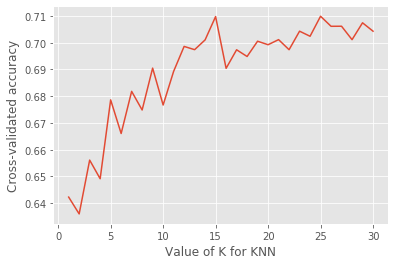

In [46]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

# Pipelines: Machine learning workflows

There are standard workflows in a machine learning project that can be automated.

In Python scikit-learn, Pipelines help to to clearly define and automate these workflows.

In this section you will discover Pipelines in scikit-learn and how you can automate common machine learning workflows.

## Pipeline Example: Data Preparation and Modeling

An easy trap to fall into in applied machine learning is leaking data from your training dataset to your test dataset.

To avoid this trap you need a robust test harness with strong separation of training and testing. This includes data preparation.

Data preparation is one easy way to leak knowledge of the whole training dataset to the algorithm. For example, preparing your data using normalization or standardization on the entire training dataset before learning would not be a valid test because the training dataset would have been influenced by the scale of the data in the test set.

Pipelines help you prevent data leakage in your test harness by ensuring that data preparation like standardization is constrained to each fold of your cross validation procedure.

The example below demonstrates this important data preparation and model evaluation workflow. The pipeline is defined with two steps:

1. Standardize the data.
* Learn a Linear Discriminant Analysis model.

The pipeline is then evaluated using 10-fold cross validation.

### Dataset diabetes in Pima Indian women 

The input-output features are as follows 
* In this dataset the input features include: 'preg' (number of times pregnent), 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 
* The `'class'` feature is the target classification variable denoting that a person (a female Indian) has diabetes or not.

In [62]:
dataframe=read_csv('/Users/aakash/Desktop/datasets_228_482_diabetes.csv')
dataframe

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [66]:
dataframe=read_csv('/Users/aakash/Desktop/datasets_228_482_diabetes.csv')

In [67]:
# Create a pipeline that standardizes the data then creates a model
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# load data
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
#names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
#dataframe = read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# create pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))      # standardize the data
estimators.append(('lda', LinearDiscriminantAnalysis()))  #build a classifier
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print("accuracy based on 10-fold CV is ", results.mean())

accuracy based on 10-fold CV is  0.773462064251538


## Task: Use a pipeline for Hyperparameter tuning for KNN via crossfold validation

Rewrite the task in [this section](#Task:-Hyperparameter-tuning-for-KNN-via-crossfold-validation) on the Wine Quality dataset using the pipeline workflow (of standardization, KNN). 

* Wine Quality (Hint: look at the pima solution or be brave and write it yourself)
* Pima Indian dataset (Pima subtask is complete below)

In the case of each data set:

* Determine the optimal value of K for a KNN classifier for the wine quality dateset using N-fold cross validation when n=10.
* What is the optimal value of K. Report the performance of accuracy on the held out test dataset.
* Please feel free to adopt the following code for this task.

In [70]:
#provide X, and Y and run this cell 

from sklearn.model_selection import cross_val_score
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []
# create pipeline

# 1. we will loop through reasonable values of k
for k in k_range:
    # create pipeline
    estimators = []
    estimators.append(('standardize', StandardScaler()))      # standardize the data
    estimators.append(('knn', neighbors.KNeighborsClassifier(n_neighbors=k)))
    model = Pipeline(estimators)
    # evaluate pipeline
    seed = 7
    #kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(model, Xs, y, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)

[0.642276358451502, 0.6391279200359389, 0.6536245800617211, 0.6460384438845267, 0.6723636665494745, 0.6660507734677136, 0.6905516572913004, 0.6842114438063986, 0.6930282188757373, 0.6804417897183483, 0.6880320520332825, 0.6948563908746436, 0.6917664752529397, 0.6998059738661666, 0.7073061691862963, 0.6929346117035821, 0.6986260449626938, 0.6998292657916325, 0.7036848119067152, 0.7030051711004337, 0.7024230682839173, 0.7017706990507441, 0.7030559299191375, 0.6986652066486971, 0.7117867153013788, 0.7030169147232314, 0.7099234100941443, 0.7005207967108089, 0.707450730497285, 0.7074234100941442]


Text(0, 0.5, 'Cross-validated accuracy')

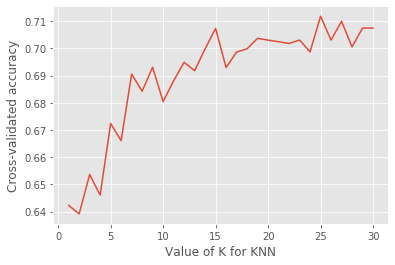

In [71]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

# KNN for regression: predict life satisfaction

In this example we will explore if money makes people happy. This is a has a rather elaborate data prep process. To do this we perform the following steps:

* Download Data
  1. Download the Better Life Index data from the OECD’s website 
  *  Download as stats about GDP per capita from the IMF’s website. 
  * Then you join the tables and sort by GDP per capita.
  * Table 1-1 below shows an excerpt of what you get after joining the two datasets (and dropping lots of other attributes).
* Build a simple linear regression models to predict `Life satisfaction` from `GDP_per_capita`
  * Explore linear regression
  * polynomial simple regression (of order 60)
  * Regularized linear regression
* Build a KNN model to predict `Life satisfaction` from `GDP_per_capita`

Table 1-1 below shows an excerpt of what you get after joining the two datasets (and dropping lots of other attributes).
	
    
|Country|GDP_per_capita|Life_satisfaction|	
|:---:|:---:|:---:|
|Brazil|	8669.998|7.0|
|Mexico	|9009.280|6.7|
|Russia	|9054.914|6.0|
|Turkey	|9437.372|5.6|
|Hungary|12239.894|4.9|

## Set up environment

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [72]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Load and prepare Life satisfaction data

In [86]:
oecd_bli=pd.read_csv('/Users/aakash/Desktop/BLI_16072020005237491.csv', thousands=',')

In [88]:
#oecd_bli.drop(columns=['Reference Period Code', 'Reference Period','Flag Codes','Flags'], axis=1)
oecd_bli=oecd_bli.dropna(axis='columns')
oecd_bli

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Value
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,5.40
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,3.50
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,3.70
3,CAN,Canada,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,6.00
4,CZE,Czech Republic,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,TOT,Total,PC,Percentage,0,Units,0.54
2365,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,32.09
2366,LTU,Lithuania,WL_EWLH,Employees working very long hours,L,Value,MN,Men,PC,Percentage,0,Units,0.67
2367,COL,Colombia,WL_EWLH,Employees working very long hours,L,Value,WMN,Women,PC,Percentage,0,Units,19.37


In [89]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli.head(2)
print(oecd_bli.shape)

(41, 24)


In [2]:
import pandas as pd

# Download CSV from http://stats.oecd.org/index.aspx?DataSetCode=BLI
datapath = "datasets/lifesat/"

oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli.head(2)
print(oecd_bli.shape)

(37, 24)


In [90]:
oecd_bli["Life satisfaction"].head()

Country
Australia    7.3
Austria      7.1
Belgium      6.9
Brazil       6.4
Canada       7.4
Name: Life satisfaction, dtype: float64

## Load and prepare GDP per capita data

In [92]:
gdp_per_capita=pd.read_csv('/Users/aakash/Desktop/WEO_Data.csv', thousands=',',encoding='latin1', na_values="n/a")

In [93]:
gdp_per_capita

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.380,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.140,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.320,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.300,2011.0
...,...,...,...,...,...,...,...
186,Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
187,Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.150,2010.0
188,Zimbabwe,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1064.350,2012.0
189,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# Download data from http://goo.gl/j1MSKe (=> imf.org)
#gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
#                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita.head(2)

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.380,2010.0


In [96]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)
full_country_stats

,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
South Africa,22.0,37.0,73.0,18.12,43.0,36.1,13.7,NaN,NaN,18.0,...,14.92,73.0,67.0,NaN,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",5694.57,2014.0
Colombia,10.0,23.9,54.0,26.56,67.0,44.4,24.5,NaN,NaN,17.0,...,NaN,53.0,75.0,14.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",6083.51,2014.0
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,...,NaN,79.0,73.0,16.2,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8670.00,2014.0
Mexico,16.0,25.5,38.0,28.70,61.0,41.8,18.1,NaN,NaN,20.0,...,NaN,63.0,68.0,15.2,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.28,2015.0
Russia,15.0,14.8,94.0,0.14,70.0,52.8,9.6,NaN,NaN,18.0,...,NaN,68.0,55.0,16.2,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9054.91,2015.0
Turkey,20.0,8.0,39.0,32.64,52.0,59.8,1.4,NaN,NaN,20.0,...,14.79,86.0,65.0,18.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9437.37,2013.0
Hungary,19.0,4.7,84.0,3.03,68.0,56.3,1.0,NaN,104458.0,19.0,...,NaN,70.0,77.0,16.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",12239.89,2015.0
Poland,22.0,3.0,92.0,5.95,66.0,67.3,0.7,19814.0,210991.0,22.0,...,14.42,55.0,82.0,17.6,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",12495.33,2014.0
Chile,16.0,9.4,65.0,9.72,63.0,47.9,4.2,NaN,100967.0,18.0,...,NaN,47.0,71.0,17.5,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",13340.91,2014.0


## EDA of  Life satisfaction versus GDP per capita

In [97]:
full_country_stats[["GDP per capita", 'Life satisfaction']].loc["United States"]

GDP per capita       55805.2
Life satisfaction        6.9
Name: United States, dtype: float64

In [98]:
full_country_stats[["GDP per capita", 'Life satisfaction']].head(5)

,GDP per capita,Life satisfaction
Country,,
South Africa,5694.57,4.7
Colombia,6083.51,6.3
Brazil,8670.00,6.4
Mexico,9009.28,6.5
Russia,9054.91,5.8


In [99]:
print(full_country_stats.shape)

(40, 30)


## Split data into train and test (7 countries)

In [102]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

# TRAIN Dataset 
sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
# held out TEST data
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

In [103]:
sample_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8670.00,6.4
Mexico,9009.28,6.5
Russia,9054.91,5.8
Turkey,9437.37,5.5
Poland,12495.33,6.1
Latvia,13618.57,5.9
Lithuania,14210.28,5.9
Slovak Republic,15991.74,6.2
Czech Republic,17256.92,6.7


Saving figure money_happy_scatterplot


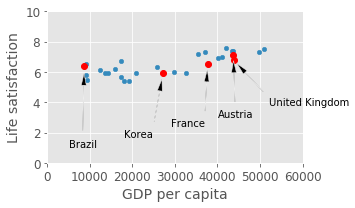

In [104]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
position_text = {
    "Brazil": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Austria": (40000, 3.0),
    "United Kingdom": (52000, 3.8),
}
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")
save_fig('money_happy_scatterplot')
plt.show()

In [105]:
sample_data.to_csv("life_satisfaction_vs_gdp_per_capita.csv")

In [106]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Brazil,8670.00,6.4
Korea,27195.20,5.9
France,37675.01,6.5
Austria,43724.03,7.1
United Kingdom,43770.69,6.8


## Some random linear regression models

Saving figure tweaking_model_params_plot


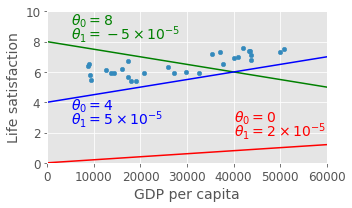

In [107]:
import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

## Learn a linear regression model via SKLearn  and plot

In [109]:
from sklearn import linear_model
lin1 = linear_model.LinearRegression()
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
lin1.fit(Xsample, ysample)
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]
t0, t1

(5.382933272778733, 3.88236978776455e-05)

Saving figure best_fit_model_plot


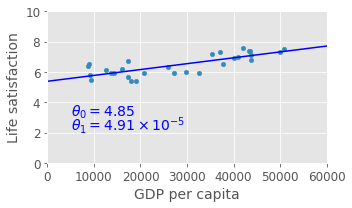

In [110]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.text(5000, 3.1, r"$\theta_0 = 4.85$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=14, color="b")
save_fig('best_fit_model_plot')
plt.show()


In [126]:
sample_data[7:10]

,GDP per capita,Life satisfaction
Country,,
Slovak Republic,15991.74,6.2
Czech Republic,17256.92,6.7
Estonia,17288.08,5.7


In [127]:
(6.2+6.7+5.7)/3

6.2

In [128]:
backup = oecd_bli, gdp_per_capita

def prepare_country_stats(oecd_bli, gdp_per_capita):
    return sample_data

## Learn a  linear regression model using SKLearn

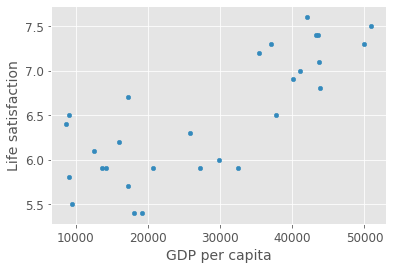

[[6.12530411]]


In [130]:
# Code example
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

# Load the data
#oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
#gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
#                             encoding='latin1', na_values="n/a")
oecd_bli=oecd_bli
gdp_per_capita=gdp_per_capita
# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Portugal
X_new = [[19121.59]]  # Portugal' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.4 actual]]

In [131]:
oecd_bli, gdp_per_capita = backup

In [132]:
missing_data

,GDP per capita,Life satisfaction
Country,,
South Africa,5694.57,4.7
Colombia,6083.51,6.3
Hungary,12239.89,5.6
Chile,13340.91,6.5
Australia,50961.87,7.3
Ireland,51350.74,7.0
Denmark,52114.17,7.6


In [136]:
position_text2 = {
    "South Africa": (1000, 9.0),
    "Colombia": (11000, 9.0),
    "Hungary": (25000, 9.0),
    "Chile": (35000, 9.0),
    "Australia": (60000, 3),
    "Ireland": (72000, 3.0),
    "Denmark": (90000, 3.0),
}

Saving figure representative_training_data_scatterplot


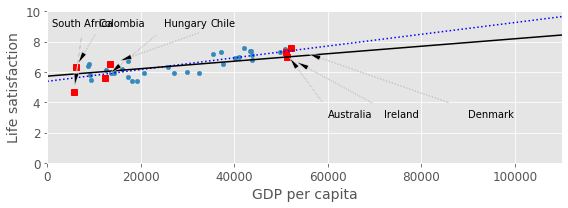

In [137]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")

save_fig('representative_training_data_scatterplot')
plt.show()

## Build a polynomial regression model (with features of order 60) for this simple linear regression model

/Users/aakash/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/Users/aakash/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Saving figure overfitting_model_plot


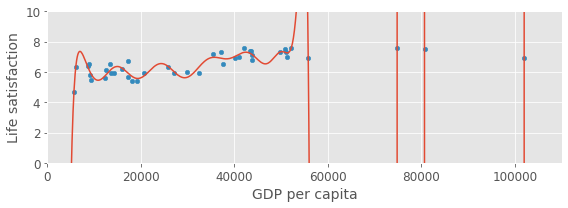

In [138]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

from sklearn import preprocessing
from sklearn import pipeline

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
save_fig('overfitting_model_plot')
plt.show()

In [139]:
#Look at countries with "W" in the spelling
full_country_stats.loc[[c for c in full_country_stats.index if "W" in c.upper()]]["Life satisfaction"]

Country
New Zealand    7.3
Sweden         7.3
Norway         7.6
Switzerland    7.5
Name: Life satisfaction, dtype: float64

Saving figure ridge_model_plot


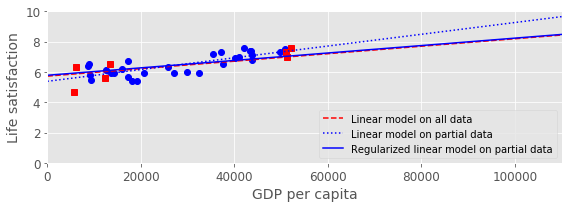

In [141]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
save_fig('ridge_model_plot')
plt.show()

## Buid a KNN Model on train and test on Cyprus

In [142]:
backup = oecd_bli, gdp_per_capita

def prepare_country_stats(oecd_bli, gdp_per_capita):
    return sample_data

In [143]:
country_stats

,GDP per capita,Life satisfaction
Country,,
Brazil,8670.00,6.4
Mexico,9009.28,6.5
Russia,9054.91,5.8
Turkey,9437.37,5.5
Poland,12495.33,6.1
Latvia,13618.57,5.9
Lithuania,14210.28,5.9
Slovak Republic,15991.74,6.2
Czech Republic,17256.92,6.7


### Predict life satisfaction for Cyprus (heldout case)

In [144]:
# Replace this linear model:
model = sklearn.linear_model.LinearRegression()

In [145]:
# with this k-neighbors regression model:
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

In [146]:
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Train the model
model.fit(X, y) #without  Cyprus' 

# Make a prediction for Cyprus
X_new = np.array([[22587.0]])  # Cyprus' GDP per capita
print(model.predict(X_new)) # outputs [[ 5.76666667]]

[[5.86666667]]
